In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

from pyspark.sql.functions import col, sum, round, countDistinct, max, variance, log10, when

from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import lit
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator



In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("HealthCareModel").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 06:11:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
part_d_data_path = "../DataSet/PrescribersByProviderDrug/Medicare_Part_D_Prescribers_by_Provider_and_Drug_2021.csv"
df = spark.read.csv(part_d_data_path, header=True, inferSchema=True)



23/12/12 06:11:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
df.printSchema()


root
 |-- Prscrbr_NPI: integer (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Prscrbr_Type_Src: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Clms: integer (nullable = true)
 |-- Tot_30day_Fills: double (nullable = true)
 |-- Tot_Day_Suply: integer (nullable = true)
 |-- Tot_Drug_Cst: double (nullable = true)
 |-- Tot_Benes: integer (nullable = true)
 |-- GE65_Sprsn_Flag: string (nullable = true)
 |-- GE65_Tot_Clms: integer (nullable = true)
 |-- GE65_Tot_30day_Fills: double (nullable = true)
 |-- GE65_Tot_Drug_Cst: double (nullable = true)
 |-- GE65_Tot_Day_Suply: integer (nullable = true)
 |-- GE65_Bene_Sprsn_Flag: string (nullable = true)
 |-- GE65_T

In [5]:
part_d_data_t = df.select(
    col("Prscrbr_NPI").alias("npi"),
    col("Prscrbr_City").alias("city"),
    col("Prscrbr_State_Abrvtn").alias("state"),
    col("Prscrbr_Last_Org_Name").alias("last_name"),
    col("Prscrbr_First_Name").alias("first_name"),
    col("Prscrbr_Type").alias("specialty"),
    col("Brnd_Name").alias("drug_name"),
    col("Gnrc_Name").alias("generic_name"),
    col("Tot_Drug_Cst").alias("total_drug_cost"),
    col("Tot_Clms").alias("total_claim_count"),
    col("Tot_Day_Suply").alias("total_day_supply")
)

In [6]:
# Step 1: Assign one DataFrame to another
part_d_pd1 = part_d_data_t

# Step 2: Select specific columns
part_d_drug_df = part_d_data_t.select("npi", "drug_name", "total_drug_cost", "total_claim_count", "total_day_supply", "specialty")

# Step 3: Change the data type of 'npi' to StringType
part_d_drug_df = part_d_drug_df.withColumn("npi", col("npi").cast(StringType()))

# Step 4: Select specific columns from another DataFrame
part_d_spec_df1 = part_d_data_t.select("npi", "specialty")

# Step 5: Show the first few rows (equivalent to head(0) in Pandas)
part_d_spec_df1.show()
part_d_drug_df.show()

+----------+-----------------+
|       npi|        specialty|
+----------+-----------------+
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
|1003000126|Internal Medicine|
+----------+-----------------+
only showing top 20 rows

+----------+--------------------+---------------+-----------------+----------------+-----------------+
|       npi|           drug_name|total_drug_cost|total_claim_count|total_day_supply|        specialty|
+----------+------------

In [7]:
part_d_pd2 = part_d_data_t.select('npi',
                                  'city',
                                  'state',
                                  'last_name',
                                  'first_name',
                                  'specialty')

part_d_pd2.show()

+----------+--------+-----+---------+----------+-----------------+
|       npi|    city|state|last_name|first_name|        specialty|
+----------+--------+-----+---------+----------+-----------------+
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medicine|
|1003000126|Bethesda|   MD|Enkeshafi|   Ardalan|Internal Medic

In [8]:
part_d_pd_u = part_d_pd2.dropDuplicates()

# Show the result
part_d_pd_u.show()

+----------+-------------+-----+---------+----------+-------------------+
|       npi|         city|state|last_name|first_name|          specialty|
+----------+-------------+-----+---------+----------+-------------------+
|1003028002|      Durango|   CO|   Haynes|      Kent|            Dentist|
|1003041476|     Oak Park|   IL| Lindgren|     Kevin|Allergy/ Immunology|
|1003043555|   Washington|   PA|  Orlosky|     Julie|    Family Practice|
|1003046939|      Spencer|   IA|  Heckert|     Kathi| Nurse Practitioner|
|1003055781|     Hartford|   CT|     Rice|     Jenny|Physician Assistant|
|1003064825|        Parma|   OH| Phillips|    Cherie|   Vascular Surgery|
|1003091539|    Fullerton|   CA|      Woo|      Kiho|  Internal Medicine|
|1003095167|      El Paso|   IL|    Tyner|Jean-Marie| Nurse Practitioner|
|1003101932|   Cumberland|   MD|     Hong|     Feiyu|  Internal Medicine|
|1003119009|     Bellevue|   WA|  Swenson|   Jessica| Nurse Practitioner|
|1003127002|       Laredo|   TX|  Rami

In [9]:
group_cols = ['npi']

part_d_pd3 = (part_d_pd1.groupBy(group_cols)
             .agg(
                 F.sum("total_drug_cost").alias("sum_total_drug_cost"),
                 F.mean("total_drug_cost").alias("mean_total_drug_cost"),
                 F.max("total_drug_cost").alias("max_total_drug_cost"),
                 F.sum("total_claim_count").alias("sum_total_claim_count"),
                 F.mean("total_claim_count").alias("mean_total_claim_count"),
                 F.max("total_claim_count").alias("max_total_claim_count"),
                 F.sum("total_day_supply").alias("sum_total_day_supply"),
                 F.mean("total_day_supply").alias("mean_total_day_supply"),
                 F.max("total_day_supply").alias("max_total_day_supply")
             ))

# Show the result
part_d_pd3.show()

+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+
|       npi|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|
+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+
|1003043209| 18613.119999999995|   930.6559999999997|            7077.18|                  355|                 17.75|                   44|               21040|               1052.0|                3000|
|1003072810|          282157.48|  3399.4877108433734|           45438.26|                 4100|    49.397590361445786|                  244|              203448|   2451.18072289156

In [10]:
part_d_pd3.count()

1017417

In [11]:
part_d_all_pd = part_d_pd3.join(part_d_pd_u, on='npi', how='left')

# Show the result
part_d_all_pd.show()

+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------+-----+-------------+----------+-------------------+
|       npi|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|         city|state|    last_name|first_name|          specialty|
+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------+-----+-------------+----------+-------------------+
|1003043209| 18613.119999999995|   930.6559999999997|            7077.18|                  355|                 17.75|                   44|               21040|               1052.0|       

In [12]:
######PART D END

In [13]:
payment_data_path="../DataSet/PaymentDataSet/OP_DTL_OWNRSHP_PGYR2021_P06302023.csv"
pds = spark.read.csv(payment_data_path, header=True, inferSchema=True)

In [14]:
pds.printSchema()

root
 |-- Change_Type: string (nullable = true)
 |-- Physician_Profile_ID: integer (nullable = true)
 |-- Physician_NPI: integer (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Middle_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Physician_Name_Suffix: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line1: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line2: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary_Type: string (nullable = true)
 |-- Physician_Specialty: string (nullable = true)
 |-- Record_ID: integer (nullable = true)
 |-- Program_Year: integer (nullable = true)

In [15]:
pds.show()

+-----------+--------------------+-------------+--------------------+---------------------+-------------------+---------------------+-----------------------------------------------+-----------------------------------------------+----------------+---------------+------------------+-----------------+------------------+---------------------+----------------------+--------------------+---------+------------+-------------------------------+-----------------+--------------------+---------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+------------------------------+--------------------------------------------------------+------------------------+
|Change_Type|Physician_Profile_ID|Physician_NPI|Physician_First_Name|Physician_Middle_Name|Physician

23/12/12 06:14:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [16]:
pds_df = pds.select(
    col("Physician_First_Name").alias("first_name"),
    col("Physician_Last_Name").alias("last_name"),
    col("Recipient_State").alias("state"),
    col("Recipient_City").alias("city"),
    col("Total_Amount_Invested_USDollars").alias("total_amount_of_payment_usd")
)

pds_df.show()

+----------+----------+-----+----------------+---------------------------+
|first_name| last_name|state|            city|total_amount_of_payment_usd|
+----------+----------+-----+----------------+---------------------------+
|     Faith|    Brosch|   DE|          NEWARK|                        0.0|
|      Troy|  Brothers|   FL|          Naples|                        0.0|
|      Anne|     Brown|   VA|        Leesburg|                        0.0|
|     David|     Brown|   FL|      FORT MYERS|                        0.0|
|    Ingrid|     Brown|   TX|      Round Rock|                        0.0|
|     Kevin|     Brown|   TX|      Round Rock|                        0.0|
|    Steven|     Brown|   FL|      Palm Coast|                        0.0|
|   Michael|   Buckley|   NC|         Raleigh|                        0.0|
|  Christin|Richardson|   NC|         Raleigh|                        0.0|
|     Kathy|Richardson|   NC|      Greensboro|                        0.0|
|    Kellyn|    Rielly|  

In [17]:
pds_df1 = (pds_df
           .groupBy('first_name', 'last_name', 'state', 'city')
           .agg(F.sum('total_amount_of_payment_usd').alias('sum_total_amount_of_payment_usd'))
           .withColumn('total_amount_of_payment_usd', F.col('sum_total_amount_of_payment_usd').cast('float')))

# Show the result
pds_df1.show()

+-----------+----------+-----+---------------+-------------------------------+---------------------------+
| first_name| last_name|state|           city|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|
+-----------+----------+-----+---------------+-------------------------------+---------------------------+
|       Mary|   Goodwin|   NC|      Asheville|                            0.0|                        0.0|
|Christopher|      Ames|   CA|  SAN FRANCISCO|                            0.0|                        0.0|
|   Rajeshri|     Patel|   NY|     Long Beach|                        38348.0|                    38348.0|
|     George|    Ferzli|   NY|  Staten Island|                        70000.0|                    70000.0|
|    Michael| Ziebelman|   FL|   Winter Haven|                            0.0|                        0.0|
|    STEPHEN|     RAMEE|   LA|    NEW ORLEANS|                            0.0|                        0.0|
|       JOHN|    VUKICH|   WI|      W

In [18]:
# Convert all string columns to uppercase
for col_name in pds_df1.columns:
    # Check if the column type is string
    if isinstance(pds_df1.schema[col_name].dataType, StringType):
        pds_df1 = pds_df1.withColumn(col_name, F.upper(F.col(col_name)))

# Show the result
pds_df1.show()

+-----------+----------+-----+---------------+-------------------------------+---------------------------+
| first_name| last_name|state|           city|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|
+-----------+----------+-----+---------------+-------------------------------+---------------------------+
|       MARY|   GOODWIN|   NC|      ASHEVILLE|                            0.0|                        0.0|
|CHRISTOPHER|      AMES|   CA|  SAN FRANCISCO|                            0.0|                        0.0|
|   RAJESHRI|     PATEL|   NY|     LONG BEACH|                        38348.0|                    38348.0|
|     GEORGE|    FERZLI|   NY|  STATEN ISLAND|                        70000.0|                    70000.0|
|    MICHAEL| ZIEBELMAN|   FL|   WINTER HAVEN|                            0.0|                        0.0|
|    STEPHEN|     RAMEE|   LA|    NEW ORLEANS|                            0.0|                        0.0|
|       JOHN|    VUKICH|   WI|      W

In [19]:
pay_part_d_fpd = part_d_all_pd.join(pds_df1, on=['last_name', 'first_name', 'city', 'state'], how='left')

# Show the result
pay_part_d_fpd.show()

+-------------+----------+-------------+-----+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------------+-------------------------------+---------------------------+
|    last_name|first_name|         city|state|       npi|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|          specialty|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|
+-------------+----------+-------------+-----+----------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------------+-------------------------------+---------------------------+
|        A

In [20]:

pay_part_d_fpd.count()

1017417

In [21]:
###PAYMENT END

In [22]:
leie_data_path = "../DataSet/LEIE.csv"
leie_df = spark.read.csv(leie_data_path, header=True, inferSchema=True)
leie_df.show()

+--------+---------+-------+--------------------+------------------+------------------+----+----------+----+--------------------+----------+-----+-----+--------+--------+--------+----------+--------+
|LASTNAME|FIRSTNAME|MIDNAME|             BUSNAME|           GENERAL|         SPECIALTY|UPIN|       NPI| DOB|             ADDRESS|      CITY|STATE|  ZIP|EXCLTYPE|EXCLDATE|REINDATE|WAIVERDATE|WVRSTATE|
+--------+---------+-------+--------------------+------------------+------------------+----+----------+----+--------------------+----------+-----+-----+--------+--------+--------+----------+--------+
|    NULL|     NULL|   NULL|#1 MARKETING SERV...|    OTHER BUSINESS|        SOBER HOME|NULL|         0|NULL|239 BRIGHTON BEAC...|  BROOKLYN|   NY|11235|  1128a1|20200319|       0|         0|    NULL|
|    NULL|     NULL|   NULL|    1 BEST CARE, INC|    OTHER BUSINESS|HOME HEALTH AGENCY|NULL|         0|NULL|2161 UNIVERSITY A...|SAINT PAUL|   MN|55114|  1128b5|20230518|       0|         0|    NULL|


In [23]:
leie_df.printSchema()

root
 |-- LASTNAME: string (nullable = true)
 |-- FIRSTNAME: string (nullable = true)
 |-- MIDNAME: string (nullable = true)
 |-- BUSNAME: string (nullable = true)
 |-- GENERAL: string (nullable = true)
 |-- SPECIALTY: string (nullable = true)
 |-- UPIN: string (nullable = true)
 |-- NPI: integer (nullable = true)
 |-- DOB: integer (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- ZIP: string (nullable = true)
 |-- EXCLTYPE: string (nullable = true)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)
 |-- WVRSTATE: string (nullable = true)



In [24]:
leie_df1 = leie_df.select(
    col('NPI').alias("npi"),
    col('EXCLTYPE').alias("is_fraud"),
    col('EXCLDATE'),
    col('REINDATE'),
    col('WAIVERDATE')
)
leie_df1.show()

+----------+--------+--------+--------+----------+
|       npi|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+--------+--------+--------+----------+
|         0|  1128a1|20200319|       0|         0|
|         0|  1128b5|20230518|       0|         0|
|1972902351|  1128b8|20220320|       0|         0|
|         0|  1128a1|19880830|       0|         0|
|         0|  1128b7|19970620|       0|         0|
|         0|  1128b6|20230227|       0|         0|
|1922348218|  1128a1|20180419|       0|         0|
|         0|  1128b5|20090319|       0|         0|
|         0|  1128a1|19940524|       0|         0|
|         0|  1128b8|20020919|       0|         0|
|         0|  1128a1|20110818|       0|         0|
|         0|  1128b8|20030720|       0|         0|
|         0|  1128b5|19970903|       0|         0|
|         0|  1128a1|19910704|       0|         0|
|         0|  1128b8|19861204|       0|         0|
|         0|  1128a1|20190620|       0|         0|
|         0|  1128a1|19911229| 

In [25]:
leie_df2 = leie_df1.filter(col('npi') != 0)
leie_df2.show()

+----------+--------+--------+--------+----------+
|       npi|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+--------+--------+--------+----------+
|1972902351|  1128b8|20220320|       0|         0|
|1922348218|  1128a1|20180419|       0|         0|
|1942476080|  1128b8|20170518|       0|         0|
|1275600959|  1128a1|20130320|       0|         0|
|1891731758|  1128b8|20170518|       0|         0|
|1265830335|  1128a1|20220818|       0|         0|
|1851631543|  1128b7|20190326|       0|         0|
|1902198435|  1128a1|20160120|       0|         0|
|1073916631|  1128b7|20210816|       0|         0|
|1437510278|  1128a1|20230420|       0|         0|
|1073682936|  1128b7|20150409|       0|         0|
|1902166028|  1128b8|20170518|       0|         0|
|1992906937|  1128b8|20140720|       0|         0|
|1104947944|  1128a1|20140820|       0|         0|
|1164669479|  1128a1|20161020|       0|         0|
|1043302250|  1128a1|20160720|       0|         0|
|1801231436|  1128a1|20211029| 

In [26]:
leie_df2 = leie_df2.withColumn('is_fraud', lit(1))
# leie_df2 = leie_df2.withColumn('is_fraud', when(col('is_fraud').isNull(), lit(0.0)).otherwise(lit(1.0)))

# Show the result
leie_df2.show()

+----------+--------+--------+--------+----------+
|       npi|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+--------+--------+--------+----------+
|1972902351|       1|20220320|       0|         0|
|1922348218|       1|20180419|       0|         0|
|1942476080|       1|20170518|       0|         0|
|1275600959|       1|20130320|       0|         0|
|1891731758|       1|20170518|       0|         0|
|1265830335|       1|20220818|       0|         0|
|1851631543|       1|20190326|       0|         0|
|1902198435|       1|20160120|       0|         0|
|1073916631|       1|20210816|       0|         0|
|1437510278|       1|20230420|       0|         0|
|1073682936|       1|20150409|       0|         0|
|1902166028|       1|20170518|       0|         0|
|1992906937|       1|20140720|       0|         0|
|1104947944|       1|20140820|       0|         0|
|1164669479|       1|20161020|       0|         0|
|1043302250|       1|20160720|       0|         0|
|1801231436|       1|20211029| 

In [27]:
# 

In [28]:
leie_df2.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- is_fraud: integer (nullable = false)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)



In [29]:
# Features Engineering 
feature_1 = pay_part_d_fpd.join(leie_df2, on='npi', how='left')

In [30]:
feature_1.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sum_total_drug_cost: double (nullable = true)
 |-- mean_total_drug_cost: double (nullable = true)
 |-- max_total_drug_cost: double (nullable = true)
 |-- sum_total_claim_count: long (nullable = true)
 |-- mean_total_claim_count: double (nullable = true)
 |-- max_total_claim_count: integer (nullable = true)
 |-- sum_total_day_supply: long (nullable = true)
 |-- mean_total_day_supply: double (nullable = true)
 |-- max_total_day_supply: integer (nullable = true)
 |-- specialty: string (nullable = true)
 |-- sum_total_amount_of_payment_usd: double (nullable = true)
 |-- total_amount_of_payment_usd: float (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)



In [31]:
#Filling 0 for NA
feature_1.fillna(0)
feature_1.show()

+----------+-------------+----------+-------------+-----+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+-------------------+-------------------------------+---------------------------+--------+--------+--------+----------+
|       npi|    last_name|first_name|         city|state|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|          specialty|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|
+----------+-------------+----------+-------------+-----+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+---------------

In [32]:
feature_1 = feature_1.withColumn('is_fraud', when(col('is_fraud') == 1.0, lit(1.0)).otherwise(lit(0.0)))


In [33]:
feature_1.count()

1017418

In [34]:
feature_1.filter(col('is_fraud') == 1).count()


240

In [35]:
feature_1.filter(col('is_fraud') == 0).count()


1017178

In [36]:
feature_l = feature_1.limit(50000)

In [37]:
feature_l.count()

50000

In [38]:
feature_2 = feature_1.filter(col('is_fraud') == 1)

In [39]:
feature_2.count()

240

In [40]:
feature_3 = feature_2.union(feature_l)

In [41]:
feature_3.count()

50240

In [42]:
feature_all_df = feature_3

In [43]:
feature_all_df.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sum_total_drug_cost: double (nullable = true)
 |-- mean_total_drug_cost: double (nullable = true)
 |-- max_total_drug_cost: double (nullable = true)
 |-- sum_total_claim_count: long (nullable = true)
 |-- mean_total_claim_count: double (nullable = true)
 |-- max_total_claim_count: integer (nullable = true)
 |-- sum_total_day_supply: long (nullable = true)
 |-- mean_total_day_supply: double (nullable = true)
 |-- max_total_day_supply: integer (nullable = true)
 |-- specialty: string (nullable = true)
 |-- sum_total_amount_of_payment_usd: double (nullable = true)
 |-- total_amount_of_payment_usd: float (nullable = true)
 |-- is_fraud: double (nullable = false)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: integer (nullable = true)
 |-- WAIVERDATE: integer (nullable = true)



In [44]:
# Scaling the features
# Apply log transformation and create new columns for differences
feature_all_df = (feature_all_df
                  .withColumn('sum_total_drug_cost', log10(col('sum_total_drug_cost') + 1.0))
                  .withColumn('sum_total_claim_count', log10(col('sum_total_claim_count') + 1.0))
                  .withColumn('sum_total_day_supply', log10(col('sum_total_day_supply') + 1.0))
                  .withColumn('sum_total_amount_of_payment_usd', log10(col('sum_total_amount_of_payment_usd') + 1.0))
                  .withColumn('mean_total_drug_cost', log10(col('mean_total_drug_cost') + 1.0))
                  .withColumn('mean_total_claim_count', log10(col('mean_total_claim_count') + 1.0))
                  .withColumn('mean_total_day_supply', log10(col('mean_total_day_supply') + 1.0))
                  .withColumn('max_total_drug_cost', log10(col('max_total_drug_cost') + 1.0))
                  .withColumn('max_total_claim_count', log10(col('max_total_claim_count') + 1.0))
                  .withColumn('max_total_day_supply', log10(col('max_total_day_supply') + 1.0))
                  .withColumn('claim_max_mean', col('max_total_claim_count') - col('mean_total_claim_count'))
                  .withColumn('supply_max_mean', col('max_total_day_supply') - col('max_total_day_supply'))
                  .withColumn('drug_max_mean', col('max_total_drug_cost') - col('mean_total_drug_cost')))

# Show the result
feature_all_df.show()




+----------+------------+------------+----------------+-----+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+---------------------+--------------------+--------------------+-------------------------------+---------------------------+--------+--------+--------+----------+-------------------+---------------+-------------------+
|       npi|   last_name|  first_name|            city|state|sum_total_drug_cost|mean_total_drug_cost|max_total_drug_cost|sum_total_claim_count|mean_total_claim_count|max_total_claim_count|sum_total_day_supply|mean_total_day_supply|max_total_day_supply|           specialty|sum_total_amount_of_payment_usd|total_amount_of_payment_usd|is_fraud|EXCLDATE|REINDATE|WAIVERDATE|     claim_max_mean|supply_max_mean|      drug_max_mean|
+----------+------------+------------+----------------+-----+-------------------+--------------------+-------------------+--------------------

In [116]:
# feature_all_df = feature_all_df.withColumn("npi", col("npi").cast(StringType()))



In [117]:
categorical_features = ['npi','last_name', 'specialty','first_name','city', 'state']

numerical_features = ['sum_total_drug_cost', 'mean_total_drug_cost','total_amount_of_payment_usd',
       'max_total_drug_cost', 'sum_total_claim_count',
       'mean_total_claim_count', 'max_total_claim_count',
       'sum_total_day_supply', 'mean_total_day_supply', 'max_total_day_supply',
    'claim_max_mean','supply_max_mean', 'drug_max_mean']

target = ['is_fraud']

In [118]:
# scikit learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np


import pandas as pd
import numpy as np
import scipy
import os 

import matplotlib.pyplot as plt


from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

import random

from scipy.stats import ttest_ind

In [119]:
feature_all = categorical_features + numerical_features + target

In [120]:
FeaturesAll_pd = feature_all_df.toPandas()
FeaturesAll_pd['npi'] = FeaturesAll_pd.npi.astype(object)

In [121]:
y = FeaturesAll_pd["is_fraud"].values
X = FeaturesAll_pd[feature_all].drop('is_fraud',axis=1)

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_valid.shape)

(40192, 19)
(10048, 19)


In [123]:
X_train[numerical_features] = X_train.loc[:,numerical_features].fillna(0) 
X_valid[numerical_features] = X_valid.loc[:,numerical_features].fillna(0) 
X_train[categorical_features] = X_train.loc[:,categorical_features].fillna('NA') 
X_valid[categorical_features] = X_valid.loc[:,categorical_features].fillna('NA')

In [124]:
scaler= StandardScaler() 
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features].values)
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features].values)

In [125]:
# Combining all feature names
all_features = categorical_features + numerical_features + target



In [126]:
print(X_train[numerical_features].dtypes)

sum_total_drug_cost            float64
mean_total_drug_cost           float64
total_amount_of_payment_usd    float64
max_total_drug_cost            float64
sum_total_claim_count          float64
mean_total_claim_count         float64
max_total_claim_count          float64
sum_total_day_supply           float64
mean_total_day_supply          float64
max_total_day_supply           float64
claim_max_mean                 float64
supply_max_mean                float64
drug_max_mean                  float64
dtype: object


In [127]:
ix_ran = FeaturesAll_pd.index.values
np.random.shuffle(ix_ran)

df_len = len(FeaturesAll_pd)
train_len = int(df_len * 0.8)  # 80% for training


ix_train = ix_ran[:train_len]
ix_valid = ix_ran[train_len:]

df_train = FeaturesAll_pd.iloc[ix_train]
df_valid = FeaturesAll_pd.iloc[ix_valid]

print(len(ix_train))
print(len(ix_valid))

40192
10048


In [128]:
print(df_train.dtypes)

npi                                 object
last_name                           object
first_name                          object
city                                object
state                               object
sum_total_drug_cost                float64
mean_total_drug_cost               float64
max_total_drug_cost                float64
sum_total_claim_count              float64
mean_total_claim_count             float64
max_total_claim_count              float64
sum_total_day_supply               float64
mean_total_day_supply              float64
max_total_day_supply               float64
specialty                           object
sum_total_amount_of_payment_usd    float64
total_amount_of_payment_usd        float32
is_fraud                           float64
EXCLDATE                            object
REINDATE                           float64
WAIVERDATE                         float64
claim_max_mean                     float64
supply_max_mean                    float64
drug_max_me

In [184]:
# part_d_drug_df_lim = feature_3.limit(100000)
# partD_Drug_pd = part_d_drug_df_lim.toPandas()

partD_Drug_pd_tmp = part_d_drug_df.join(feature_all_df.select('npi'), on='npi', how='inner')
# partD_Drug_pd_tmp = partD_Drug_pd_tmmp.limit(50000)

# partD_Drug_pd['npi'] = partD_Drug_pd.npi.astype(object)

In [185]:
# partD_Drug_pd_tmp.show()

In [186]:
partD_Drug_pd = partD_Drug_pd_tmp.toPandas()

In [187]:
# partD_Drug_pd.printSchema()

In [188]:
# part_d_drug_df.limit(100000).filter(col('is_fraud') == 1)

In [189]:
# Drug Weighted_Scores

partD_drug_train = pd.merge(partD_Drug_pd,df_train[['npi','is_fraud']], how='inner', on=['npi'])


In [190]:
partD_drug_train.head()

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
0,1003017104,Buprenorphine-Naloxone,5026.65,18,388,Psychiatry,0.0
1,1003300047,Amoxicillin,94.59,19,133,Dentist,0.0
2,1003306739,Hydrocodone-Acetaminophen,76.81,25,82,General Surgery,0.0
3,1003306739,Ibuprofen,63.44,25,128,General Surgery,0.0
4,1003340621,Amlodipine Besylate,50.01,11,691,Family Practice,0.0


In [191]:
partD_drug_All = pd.merge(partD_Drug_pd,FeaturesAll_pd[['npi','is_fraud']], how='inner', on=['npi'])

In [192]:
partD_Drug_pd.head()

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty
0,1003017104,Buprenorphine-Naloxone,5026.65,18,388,Psychiatry
1,1003300047,Amoxicillin,94.59,19,133,Dentist
2,1003306739,Hydrocodone-Acetaminophen,76.81,25,82,General Surgery
3,1003306739,Ibuprofen,63.44,25,128,General Surgery
4,1003323098,Gabapentin,116.68,12,360,Physician Assistant


In [193]:
print(len(partD_drug_train[partD_drug_train['is_fraud']==1]))

9980


In [194]:
# get unique drug names
drugs = set([ drugx for drugx in partD_drug_train['drug_name'].values if isinstance(drugx, str)])
print(len(drugs))

2130


In [195]:
partD_drug_train.head(5)

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
0,1003017104,Buprenorphine-Naloxone,5026.65,18,388,Psychiatry,0.0
1,1003300047,Amoxicillin,94.59,19,133,Dentist,0.0
2,1003306739,Hydrocodone-Acetaminophen,76.81,25,82,General Surgery,0.0
3,1003306739,Ibuprofen,63.44,25,128,General Surgery,0.0
4,1003340621,Amlodipine Besylate,50.01,11,691,Family Practice,0.0


In [196]:
print("Total records in train set : ")
print(len(partD_drug_train))
print("Total Fraud in train set : ")
print(len(partD_drug_train[partD_drug_train['is_fraud']==1]))
partD_drug_train.head()

Total records in train set : 
925421
Total Fraud in train set : 
9980


,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
0,1003017104,Buprenorphine-Naloxone,5026.65,18,388,Psychiatry,0.0
1,1003300047,Amoxicillin,94.59,19,133,Dentist,0.0
2,1003306739,Hydrocodone-Acetaminophen,76.81,25,82,General Surgery,0.0
3,1003306739,Ibuprofen,63.44,25,128,General Surgery,0.0
4,1003340621,Amlodipine Besylate,50.01,11,691,Family Practice,0.0


In [197]:
cols = ['total_drug_cost','total_claim_count','total_day_supply']

In [198]:
partD_drug_train_Group = partD_drug_train.groupby(['drug_name', 'is_fraud'])
partD_drug_All_Group = partD_drug_All.groupby(['drug_name', 'is_fraud'])

In [199]:
drug_keys = partD_drug_train_Group.groups.keys()
print(len(drug_keys))

2951


In [200]:
drug_keys

dict_keys([('1st Tier Unifine Pentips', 0.0), ('1st Tier Unifine Pentips Plus', 0.0), ('Abacavir', 0.0), ('Abacavir', 1.0), ('Abacavir-Lamivudine', 0.0), ('Abacavir-Lamivudine', 1.0), ('Abacavir-Lamivudine-Zidovudine', 0.0), ('Abilify', 0.0), ('Abilify Maintena', 0.0), ('Abiraterone Acetate', 0.0), ('Abiraterone Acetate', 1.0), ('Acamprosate Calcium', 0.0), ('Acarbose', 0.0), ('Acarbose', 1.0), ('Accupril', 0.0), ('Acebutolol Hcl', 0.0), ('Acebutolol Hcl', 1.0), ('Acetaminophen-Codeine', 0.0), ('Acetaminophen-Codeine', 1.0), ('Acetazolamide', 0.0), ('Acetazolamide', 1.0), ('Acetazolamide Er', 0.0), ('Acetic Acid', 0.0), ('Acetylcysteine', 0.0), ('Acetylcysteine', 1.0), ('Aciphex', 0.0), ('Acitretin', 0.0), ('Actemra', 0.0), ('Actemra Actpen', 0.0), ('Acthar', 0.0), ('Acthib', 0.0), ('Activella', 0.0), ('Actonel', 0.0), ('Acyclovir', 0.0), ('Acyclovir', 1.0), ('Adacel Tdap', 0.0), ('Adakveo', 0.0), ('Adapalene', 0.0), ('Adapalene', 1.0), ('Adcetris', 0.0), ('Adcirca', 0.0), ('Adderall',

In [201]:
drug_with_isfraud = [drugx for drugx in drugs if ((drugx,0.0) in drug_keys ) & ( (drugx,1.0) in drug_keys)]

In [202]:
from scipy.stats import ttest_ind
re_drug_tt = dict()
for drugx in drug_with_isfraud:
    for colx in cols:
        fraud_0 = partD_drug_train_Group.get_group((drugx,0.0))[colx].values
        fraud_1 = partD_drug_train_Group.get_group((drugx,1.0))[colx].values
        # print len(fraud_0), len(fraud_1)
        if (len(fraud_0)>2) & (len(fraud_1)>2) :
            tt = ttest_ind(fraud_0, fraud_1)
            re_drug_tt[(drugx, colx)] = tt

/Users/Shubham/Desktop/Projects/MedicareFraudDetection/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [203]:
#Setting Probilities
Prob_005 = [(key, p) for (key, (t, p)) in re_drug_tt.items() if p <=0.05]  
print(len(Prob_005))

309


In [204]:
inx=100
drug_name = Prob_005[inx][0][0]
print(drug_name)
df_bar = pd.concat([partD_drug_All_Group.get_group((Prob_005[inx][0][0],0.0)), partD_drug_All_Group.get_group((Prob_005[inx][0][0],1.0))])
df_bar.head()

Lactulose


,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty,is_fraud
2018,1003827692,Lactulose,442.78,19,614,Internal Medicine,0.0
2528,1013351279,Lactulose,178.42,13,80,Family Practice,0.0
3788,1023250073,Lactulose,441.95,26,613,Family Practice,0.0
4143,1033200688,Lactulose,539.54,13,469,Family Practice,0.0
5022,1033187208,Lactulose,256.09,13,210,Gastroenterology,0.0


In [205]:
Feture_DrugWeighted = []
new_col_all =[]
for i, p005x in enumerate(Prob_005):
    #if i>4:
    #   break
    drug_name = p005x[0][0]
    cat_name = p005x[0][1] 
    
    new_col = drug_name+'_'+cat_name
    new_col_all.append(new_col)

    drug_0 = partD_drug_All_Group.get_group((drug_name,0.0))[['npi', cat_name]]
    drug_1 = partD_drug_All_Group.get_group((drug_name,1.0))[['npi', cat_name]]

    drug_01 = pd.concat([drug_0, drug_1])
    drug_01.rename(columns={cat_name: new_col}, inplace=True)
    Feture_DrugWeighted.append(drug_01)

In [206]:
npi_col = FeaturesAll_pd[['npi']]

w_npi = []

for n, nx in enumerate(Feture_DrugWeighted):
      nggx = pd.merge(npi_col, nx.drop_duplicates(['npi']), on='npi', how='left')
      w_npi.append(nggx)

In [207]:
FeaturesAll_pd1 = FeaturesAll_pd

In [208]:
for wx in w_npi:
    col_n = wx.columns[1]
    FeaturesAll_pd1[col_n] = wx[col_n].values
    
wx = w_npi[0]
wx.columns[1]
col_n = wx.columns[1]

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_4511/2008318899.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1[col_n] = wx[col_n].values
/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_4511/2008318899.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1[col_n] = wx[col_n].values
/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_4511/2008318899.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [209]:
len(wx[col_n].values)
FeaturesAll_pd1.fillna(0)

,npi,last_name,first_name,city,state,sum_total_drug_cost,mean_total_drug_cost,max_total_drug_cost,sum_total_claim_count,mean_total_claim_count,...,Tramadol Hcl-Acetaminophen_total_day_supply,Allopurinol_total_claim_count,Amantadine_total_drug_cost,Amantadine_total_claim_count,Amantadine_total_day_supply,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Celecoxib_total_day_supply,Suboxone_total_drug_cost,Suboxone_total_day_supply
0,1053733857,Lavache,Kateline,Atlanta,GA,2.932991,2.236043,2.402932,1.819544,1.146128,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,1083643704,Zarkadas,Konstantinos,New York,NY,5.898396,3.869071,5.138398,3.743667,1.722511,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,1083654669,Samuels,Garfield,Virginia Beach,VA,5.679285,3.611204,4.749365,3.748653,1.689362,...,0.0,24.0,0.0,0.0,0.0,1025.84,38.0,1155.0,0.00,0.0
3,1124065966,Titus,Ajeeb,Bethlehem,PA,4.547852,2.925107,4.007436,2.938520,1.335315,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,1144370933,Jones,Mark,Colorado Springs,CO,4.847749,3.671744,4.482758,2.674861,1.511438,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,21036.81,1025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50235,1205025160,Ches,Nicole,Houston,TX,4.133206,3.133494,3.906398,2.597695,1.607455,...,0.0,0.0,0.0,0.0,0.0,1794.97,24.0,780.0,0.00,0.0
50236,1205025335,Kestler,Margaret,Saratoga Springs,NY,4.963002,3.531761,4.782212,2.792392,1.378869,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
50237,1205025988,Shapiro,Jerry,New York,NY,4.372206,3.293228,3.792933,2.740363,1.669782,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
50238,1205025996,Jumagdao-Sakai,Maria Delie,Gilroy,CA,5.440511,3.462935,4.634885,3.617734,1.649745,...,0.0,44.0,0.0,0.0,0.0,634.38,12.0,1020.0,0.00,0.0


In [210]:
len(wx[col_n].values)
FeaturesAll_pd1.fillna(0)

,npi,last_name,first_name,city,state,sum_total_drug_cost,mean_total_drug_cost,max_total_drug_cost,sum_total_claim_count,mean_total_claim_count,...,Tramadol Hcl-Acetaminophen_total_day_supply,Allopurinol_total_claim_count,Amantadine_total_drug_cost,Amantadine_total_claim_count,Amantadine_total_day_supply,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Celecoxib_total_day_supply,Suboxone_total_drug_cost,Suboxone_total_day_supply
0,1053733857,Lavache,Kateline,Atlanta,GA,2.932991,2.236043,2.402932,1.819544,1.146128,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,1083643704,Zarkadas,Konstantinos,New York,NY,5.898396,3.869071,5.138398,3.743667,1.722511,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,1083654669,Samuels,Garfield,Virginia Beach,VA,5.679285,3.611204,4.749365,3.748653,1.689362,...,0.0,24.0,0.0,0.0,0.0,1025.84,38.0,1155.0,0.00,0.0
3,1124065966,Titus,Ajeeb,Bethlehem,PA,4.547852,2.925107,4.007436,2.938520,1.335315,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,1144370933,Jones,Mark,Colorado Springs,CO,4.847749,3.671744,4.482758,2.674861,1.511438,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,21036.81,1025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50235,1205025160,Ches,Nicole,Houston,TX,4.133206,3.133494,3.906398,2.597695,1.607455,...,0.0,0.0,0.0,0.0,0.0,1794.97,24.0,780.0,0.00,0.0
50236,1205025335,Kestler,Margaret,Saratoga Springs,NY,4.963002,3.531761,4.782212,2.792392,1.378869,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
50237,1205025988,Shapiro,Jerry,New York,NY,4.372206,3.293228,3.792933,2.740363,1.669782,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
50238,1205025996,Jumagdao-Sakai,Maria Delie,Gilroy,CA,5.440511,3.462935,4.634885,3.617734,1.649745,...,0.0,44.0,0.0,0.0,0.0,634.38,12.0,1020.0,0.00,0.0


In [211]:
FeaturesAll_pd1[new_col_all].describe()

,Advair Diskus_total_drug_cost,Advair Diskus_total_claim_count,Nifedipine Er_total_claim_count,Doxycycline Hyclate_total_drug_cost,Dextroamphetamine-Amphetamine_total_drug_cost,Dextroamphetamine-Amphetamine_total_claim_count,Dextroamphetamine-Amphetamine_total_day_supply,Easy Touch Alcohol Prep Pads_total_drug_cost,Easy Touch Alcohol Prep Pads_total_claim_count,Easy Touch Alcohol Prep Pads_total_day_supply,...,Tramadol Hcl-Acetaminophen_total_day_supply,Allopurinol_total_claim_count,Amantadine_total_drug_cost,Amantadine_total_claim_count,Amantadine_total_day_supply,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Celecoxib_total_day_supply,Suboxone_total_drug_cost,Suboxone_total_day_supply
count,2323.000000,2323.000000,3525.000000,4910.000000,1787.000000,1787.000000,1787.000000,216.000000,216.000000,216.000000,...,412.000000,7744.000000,554.000000,554.000000,554.000000,4361.000000,4361.000000,4361.000000,318.000000,318.000000
mean,13734.654580,24.311235,32.552057,729.316173,1322.096083,31.687745,974.329043,123.831713,27.643519,1187.763889,...,435.623786,49.034995,2139.333014,31.122744,1264.873646,1713.582371,35.189635,1709.992892,15653.531006,754.462264
std,12953.691704,22.391628,39.251834,970.565941,1773.238141,38.859408,1215.322674,108.295123,26.398340,1290.496474,...,454.401156,48.161889,3241.718603,49.296821,2082.562601,2259.658270,41.326720,1836.139194,21299.661920,853.018543
min,912.090000,11.000000,11.000000,26.260000,25.250000,11.000000,39.000000,27.560000,11.000000,226.000000,...,30.000000,11.000000,86.730000,11.000000,177.000000,10.600000,11.000000,11.000000,622.340000,39.000000
25%,7198.950000,13.000000,14.000000,251.507500,493.610000,13.000000,390.000000,64.327500,13.000000,471.750000,...,232.250000,19.000000,693.512500,13.000000,390.000000,638.910000,15.000000,739.000000,6010.462500,360.000000
50%,10338.200000,18.000000,20.000000,429.550000,789.640000,19.000000,600.000000,92.570000,19.000000,828.000000,...,340.500000,34.000000,1216.110000,19.000000,700.000000,1115.670000,23.000000,1185.000000,9965.055000,506.000000
75%,15248.825000,26.000000,35.000000,835.730000,1487.520000,34.000000,1063.000000,147.260000,32.000000,1361.500000,...,487.250000,62.000000,2393.390000,35.000000,1314.000000,2055.720000,39.000000,2040.000000,19063.997500,855.250000
max,152663.180000,324.000000,671.000000,25123.250000,30770.260000,736.000000,22630.000000,1131.060000,270.000000,14022.000000,...,5899.000000,890.000000,45704.420000,970.000000,28940.000000,60328.860000,966.000000,31145.000000,266073.820000,10373.000000


In [212]:
FeaturesAll_pd1['drug_mean'] = FeaturesAll_pd1[new_col_all].mean(axis=1)

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_4511/2904475860.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['drug_mean'] = FeaturesAll_pd1[new_col_all].mean(axis=1)


In [213]:
FeaturesAll_pd['drug_mean'] = FeaturesAll_pd['drug_mean'].map(lambda x: np.log10(x + 1.0))

In [214]:
FeaturesAll_pd1['drug_sum'] = FeaturesAll_pd1[new_col_all].sum(axis=1)
FeaturesAll_pd['drug_sum'] = FeaturesAll_pd['drug_sum'].map(lambda x: np.log10(x + 1.0))

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_4511/2891881099.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['drug_sum'] = FeaturesAll_pd1[new_col_all].sum(axis=1)


In [215]:
FeaturesAll_pd1['drug_variance'] = FeaturesAll_pd1[new_col_all].var(axis=1)

/var/folders/xt/5tggmx0n5yn01wlq09ktvkbc0000gr/T/ipykernel_4511/3871928060.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FeaturesAll_pd1['drug_variance'] = FeaturesAll_pd1[new_col_all].var(axis=1)


In [216]:
FeaturesAll_pd1

,npi,last_name,first_name,city,state,sum_total_drug_cost,mean_total_drug_cost,max_total_drug_cost,sum_total_claim_count,mean_total_claim_count,...,Amantadine_total_claim_count,Amantadine_total_day_supply,Celecoxib_total_drug_cost,Celecoxib_total_claim_count,Celecoxib_total_day_supply,Suboxone_total_drug_cost,Suboxone_total_day_supply,drug_mean,drug_sum,drug_variance
0,1053733857,Lavache,Kateline,Atlanta,GA,2.932991,2.236043,2.402932,1.819544,1.146128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.102524,3.002602,2.315598e+04
1,1083643704,Zarkadas,Konstantinos,New York,NY,5.898396,3.869071,5.138398,3.743667,1.722511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.564228,5.707125,1.918533e+08
2,1083654669,Samuels,Garfield,Virginia Beach,VA,5.679285,3.611204,4.749365,3.748653,1.689362,...,NaN,NaN,1025.84,38.0,1155.0,NaN,NaN,2.997945,5.030936,4.223704e+06
3,1124065966,Titus,Ajeeb,Bethlehem,PA,4.547852,2.925107,4.007436,2.938520,1.335315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.607956,4.314475,2.223817e+05
4,1144370933,Jones,Mark,Colorado Springs,CO,4.847749,3.671744,4.482758,2.674861,1.511438,...,NaN,NaN,NaN,NaN,NaN,21036.81,1025.0,3.211285,4.572757,2.165488e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50235,1205025160,Ches,Nicole,Houston,TX,4.133206,3.133494,3.906398,2.597695,1.607455,...,NaN,NaN,1794.97,24.0,780.0,NaN,NaN,2.992093,4.353398,3.373924e+06
50236,1205025335,Kestler,Margaret,Saratoga Springs,NY,4.963002,3.531761,4.782212,2.792392,1.378869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50237,1205025988,Shapiro,Jerry,New York,NY,4.372206,3.293228,3.792933,2.740363,1.669782,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50238,1205025996,Jumagdao-Sakai,Maria Delie,Gilroy,CA,5.440511,3.462935,4.634885,3.617734,1.649745,...,NaN,NaN,634.38,12.0,1020.0,NaN,NaN,3.142585,5.150876,2.443730e+07


In [283]:
df_train = FeaturesAll_pd1.iloc[ix_train]
df_valid = FeaturesAll_pd1.iloc[ix_valid]

df_train = df_train.fillna(0)
df_valid = df_valid.fillna(0)

In [284]:
df_valid.columns

Index(['npi', 'last_name', 'first_name', 'city', 'state',
       'sum_total_drug_cost', 'mean_total_drug_cost', 'max_total_drug_cost',
       'sum_total_claim_count', 'mean_total_claim_count',
       ...
       'Amantadine_total_day_supply', 'Celecoxib_total_drug_cost',
       'Celecoxib_total_claim_count', 'Celecoxib_total_day_supply',
       'Suboxone_total_drug_cost', 'Suboxone_total_day_supply', 'drug_mean',
       'drug_sum', 'drug_variance', 'Spec_Weight'],
      dtype='object', length=337)

In [285]:
#Create the Specialty Weight
spec_dict =[]
spec_fraud_1 = df_train[df_train['is_fraud']==1]['specialty']

In [286]:
from collections import Counter
counts = Counter(spec_fraud_1)
spec_dict =  dict(counts)

In [287]:
FeaturesAll_pd1['Spec_Weight'] = FeaturesAll_pd1['specialty'].map(lambda x: spec_dict.get(x, 0))

In [288]:
df_train = FeaturesAll_pd1.iloc[ix_train]
df_valid = FeaturesAll_pd1.iloc[ix_valid]

In [289]:
len(df_train[df_train['is_fraud'] == 1])


205

In [290]:
print(df_train.dtypes)

npi                           object
last_name                     object
first_name                    object
city                          object
state                         object
                              ...   
Suboxone_total_day_supply    float64
drug_mean                    float64
drug_sum                     float64
drug_variance                float64
Spec_Weight                    int64
Length: 337, dtype: object


In [291]:
df_train = df_train.fillna(0)

In [296]:
df_valid = df_valid.fillna(0)


In [297]:
numerical_features1 = numerical_features + ['drug_sum','Spec_Weight']


In [298]:
numerical_features1

['sum_total_drug_cost',
 'mean_total_drug_cost',
 'total_amount_of_payment_usd',
 'max_total_drug_cost',
 'sum_total_claim_count',
 'mean_total_claim_count',
 'max_total_claim_count',
 'sum_total_day_supply',
 'mean_total_day_supply',
 'max_total_day_supply',
 'claim_max_mean',
 'supply_max_mean',
 'drug_max_mean',
 'drug_sum',
 'Spec_Weight']

In [299]:
positives=len(df_train[df_train['is_fraud'] == 1])
positives

205

In [300]:
dataset_size=len(df_train)
dataset_size

40192

In [301]:
per_ones=(float(positives)/float(dataset_size))*100
per_ones

0.5100517515923566

In [302]:
negatives=float(dataset_size-positives)
t=negatives/positives
t

195.05853658536586

In [303]:
BalancingRatio= positives/dataset_size
BalancingRatio

0.005100517515923567

In [304]:
df_train = df_train.fillna(0)

In [305]:
X= df_train[numerical_features1].values
print(X)

[[ 5.86420565  3.52191297  0.         ...  1.37556346  5.57891147
  47.        ]
 [ 3.21275475  2.36925032  0.         ...  0.24005588  3.39888227
  38.        ]
 [ 4.97409977  3.16821012  0.         ...  1.40748311  4.6308459
  16.        ]
 ...
 [ 4.693567    3.18868957  0.         ...  0.72860793  4.38464619
   4.        ]
 [ 5.52903637  3.64831911  0.         ...  1.24278049  5.00013669
  47.        ]
 [ 5.21879346  3.67481463  0.         ...  1.17834537  3.71875239
   4.        ]]


In [306]:
X= df_train[numerical_features1].values
Y = df_train['is_fraud'].values
clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
clf.fit(X,Y)
y_p=clf.predict_proba(X)


/Users/Shubham/Desktop/Projects/MedicareFraudDetection/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [307]:
# X= df_train[numerical_features1].values
# Y = df_train['is_fraud'].values
# clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
# clf.fit(X,Y)
# y_p=clf.predict_proba(X)

In [308]:
params_0 = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 3, 'learning_rate': 0.01}
params_1 = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'class_weight' : {0:1, 1:2514}, 'n_jobs':5}

scaler = StandardScaler()
    
clfs = [
    LogisticRegression(C=1e5,class_weight= {0:1, 1:2514}, n_jobs=5),
    
    GaussianNB(),

    ensemble.RandomForestClassifier(**params_1),

    ensemble.ExtraTreesClassifier(**params_1),
    
    ensemble.GradientBoostingClassifier(**params_0)
    
    ]

In [309]:
X_train = df_train[numerical_features1].values

y_train = df_train['is_fraud'].values
    
X_train = scaler.fit_transform(X_train)

X_valid = df_valid[numerical_features1].values
y_valid = df_valid['is_fraud'].values
X_valid_x= scaler.transform(X_valid)


# # Imputer for filling "NaN" values with the mean of the column
# imputer = SimpleImputer(strategy='mean')

# # Apply the imputer to your training and validation data
# X_train = imputer.fit_transform(X_train)
# X_valid_x = imputer.transform(X_valid_x)

In [310]:


prob_result = []
df_m = []
clfs_fited = []
for clf in clfs:
    print("%s:" %  clf.__class__.__name__)
    clf.fit(X_train,y_train)
    clfs_fited.append(clf)
    y_pred = clf.predict(X_valid_x)
    prob_pos  = clf.predict_proba(X_valid_x)[:, 1]
    prob_result.append(prob_pos)
    m = confusion_matrix(y_valid, y_pred)
    clf_score = brier_score_loss(y_valid, prob_pos, pos_label=y_valid.max())
    print("\tBrier: %1.5f" % (clf_score))
    print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred))
    print("\tRecall: %1.5f" % recall_score(y_valid, y_pred))
    print("\tF1: %1.5f" % f1_score(y_valid, y_pred))
    print("\tauc: %1.5f" % roc_auc_score(y_valid, prob_pos))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred))
    df_m.append(
        pd.DataFrame(m, index=['True Negative', 'True Positive'], columns=['Pred. Negative', 'Pred. Positive'])
        )

LogisticRegression:
	Brier: 0.79648
	Precision: 0.00428
	Recall: 1.00000
	F1: 0.00853
	auc: 0.66093
	Accuracy: 0.00518

GaussianNB:
	Brier: 0.02088
	Precision: 0.01395
	Recall: 0.06977
	F1: 0.02326
	auc: 0.69148
	Accuracy: 0.97492

RandomForestClassifier:
	Brier: 0.37053
	Precision: 0.00589
	Recall: 0.79070
	F1: 0.01170
	auc: 0.67450
	Accuracy: 0.42834

ExtraTreesClassifier:
	Brier: 0.49882
	Precision: 0.00486
	Recall: 0.95349
	F1: 0.00967
	auc: 0.70499
	Accuracy: 0.16381

GradientBoostingClassifier:
	Brier: 0.00434
	Precision: 0.00000
	Recall: 0.00000
	F1: 0.00000
	auc: 0.71046
	Accuracy: 0.99552



In [311]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_result[2])


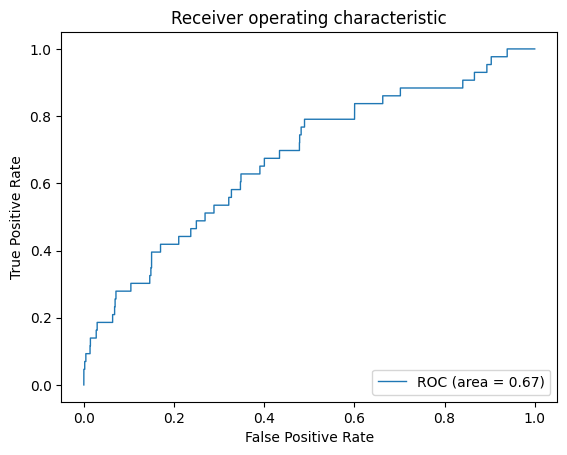

In [312]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_result[2])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
